In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pace_neutrons import Matlab
m = Matlab()

# Set SpinW to use mex files:
swp = m.swpref()
swp.usemex = 1

Trying MATLAB version: 2022b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2022b.ctf))
Searching for Matlab 9.13 in /opt/matlab2021b
Searching for Matlab 9.13 in /opt
Trying MATLAB version: 2021b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2021b.ctf))
Searching for Matlab 9.11 in /opt/matlab2021b
Found Matlab 9.11 glnxa64 at /opt/matlab2021b
Interface opened
All features have moved to hor_config


!==================================================================!

!          ISIS utilities for visualization and analysis           !
!                   of neutron spectroscopy data                   !
!                          Herbert 4.0.0                           !
!------------------------------------------------------------------!


All features have moved to hor_config

!==================================================================!
!
!--------------------------------

## I. Powder fitting

Setup spinw model for MnF2

In [2]:
J1 = -0.05;
J2 = 0.3;
D = 0.05;

mnf2 = m.spinw();
mnf2.genlattice('lat_const', [4.87, 4.87, 3.31], 'angled', [90, 90, 90], 'sym', 'P 42/m n m');
mnf2.addatom('r', [0, 0, 0], 'S', 2.5, 'label', 'MMn2', 'color', 'b')
mnf2.gencoupling('maxDistance', 5)
mnf2.addmatrix('label', 'J1', 'value', J1, 'color', 'red');
mnf2.addmatrix('label', 'J2', 'value', J2, 'color', 'green');
mnf2.addcoupling('mat', 'J1', 'bond', 1)
mnf2.addcoupling('mat', 'J2', 'bond', 2)
mnf2.addmatrix('label', 'D', 'value', np.diag([0, 0, D]), 'color', 'black');
mnf2.addaniso('D')
mnf2.genmagstr('mode', 'direct', 'S', [[0, 0],[0, 0],[1, -1]])

Creating the bond list (maxDistance = 5 Å, nCell = 2x2x2)...

...14 bonds are retained out of 300 generated!



array([], shape=(0, 0), dtype=float64)

Setup fit model and resolution functions

In [5]:
# define fit_func (changes parameters in spinw object)
fit_func =  m.eval("@(obj, p) matparser(obj, 'param', p, 'mat', {'J1', 'J2', 'D(3,3)'}, 'init', true)");

# Resolution (from PyChop)
Ei = 20;
eres = m.eval(f'@(en) 512.17*sqrt(({Ei}-en).^3 .* ( 8.26326e-10*(0.169+0.4*({Ei}./({Ei}-en)).^1.5).^2 + 2.81618e-11*(1.169+0.4*({Ei}./({Ei}-en)).^1.5).^2))')
# Q-resolution (parameters for MARI)
e2k = m.eval('@(en) sqrt( en .* (2*1.67492728e-27*1.60217653e-22) )./1.05457168e-34./1e10');
L1 = 11.8;  # Moderator to Sample distance in m
L2 = 2.5;   # Sample to detector distance in m
ws = 0.05;  # Width of sample in m
wm = 0.12;  # Width of moderator in m
wd = 0.025; # Width of detector in m
ki = np.sqrt( Ei * (2*1.67492728e-27*1.60217653e-22) )/1.05457168e-34/1e10;
a1 = ws/L1; # Angular width of sample seen from moderator
a2 = wm/L1; # Angular width of moderator seen from sample
a3 = wd/L2; # Angular width of detector seen from sample
a4 = ws/L2; # Angular width of sample seen from detector
dQ = 2.35 * np.sqrt( (ki*a1)**2/12 + (ki*a2)**2/12 + (ki*a3)**2/12 + (ki*a4)**2/12 )

Setup fit powder class

In [9]:
mnf2dat = m.load("./mnf2.mat")
fitpow = m.sw_fitpowder(mnf2, mnf2dat,  fit_func, [J1, J2, D])
fitpow.set_caching(True)
fitpow.crop_energy_range(2.0, 10.0)
fitpow.crop_q_range(0.4, 3.5)
fitpow.powspec_args['dE'] = eres.handle
fitpow.powspec_args.fastmode = True
fitpow.powspec_args.neutron_output = True
fitpow.sw_instrument_args = {'dQ': dQ, 'ThetaMin': 3.5, 'Ei': Ei}
fitpow.estimate_constant_background()
fitpow.estimate_scale_factor()
fitpow.set_model_parameter_bounds([1,2,3], [-1, 0, -0.2], [0, 1, 0.2]) # Force J1 to be ferromagnetic to agree with structure
fitpow.set_bg_parameter_bounds(3, 0.0, []) # Set lb of constant bg = 0
fitpow.fix_bg_parameters([1,2]); # fix slopes of background to 0
fitpow.cost_function = "Rsq";  # "Rsq" or "chisq"
fitpow.optimizer = m.eval('@ndbase.lm')
result = fitpow.fit('MaxIter', 0)

Calculating powder spectra...
The magnetic form factor is included in the calculated structure factor.

                                        


Calculation finished.

Finite instrumental momentum resolution of 0.053 A-1 is applied.

Energy transfer is limited to instrument, using ki=3.107 A-1.

Calculating powder spectra...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.

Calculation finished.

Finite instrumental momentum resolution of 0.053 A-1 is applied.

Energy transfer is limited to instrument, using ki=3.107 A-1.

Calculating powder spectra...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
                                        

Calculation finished.

Finite instrumental momentum resolution of 0.053 A-1 is applied.

Energy transfer is limited to instrument, using ki=3.107 A-1.

Calculating powder spectra..

[[-7.07577141e-02  3.41368444e-01  4.06540005e-02  0.00000000e+00
   0.00000000e+00  2.59964204e-02  3.81241502e+01]]

{'msg': "Maximum Number of iterations is reached without convergence, increase 'MaxIter'!", 'warning': array([], shape=(0, 0), dtype=float64), 'p': array([[-7.07577141e-02,  3.41368444e-01,  4.06540005e-02,
         0.00000000e+00,  0.00000000e+00,  2.59964204e-02,
         3.81241502e+01]]), 'sigP': array([[6.94875860e+06       +0.j        ,
        8.72437289e+06       +0.j        ,
        0.00000000e+00-81078529.37219004j,
        0.00000000e+00-11074530.43161005j,
        0.00000000e+00-27526812.01802419j,
        3.44309577e+08       +0.j        ,
        7.29026175e+09       +0.j        ]]), 'redX2': array([[2.81856084e+09]]), 'Rsq': array([[0.]]), 'sigY': array([[38794.39813154, 38794.39813154, 38794.39813154, 38794.39813154,
        38794.39813154, 38794.39813154, 38794.39813154]]), 'corrP': array([[ 9.06355936e-07, -5.41968579e-06,  2.73402283e-05,
         1

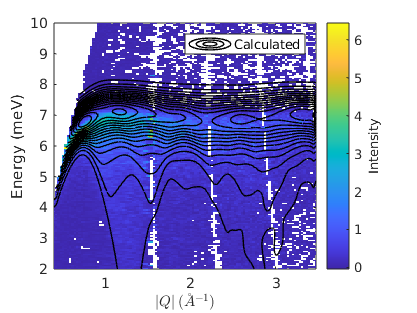

In [10]:
pfit,cost_val,stat = result;
fitpow.plot_result(pfit, 16, 'LineWidth', 1 ,'EdgeColor', 'k', nargout=0)
m.ylim([2,10])
print(pfit)
print()
print(stat)